# Custom Nucleation: Single Species

In this *How-to Guide*, we will demonstrate how to create a custom nucleation model for a single-species aerosol system. We will use fixed nucleation rates for demonstration purposes. This approach highlights the flexibility of adding new processes to your aerosol simulation before full integration into the main codebase.

This guide is based on the **Dynamics Customization** tutorial.

**Imports**

In [ ]:
# In Colab uncomment the following command to install particula:
#!pip install particula[extra] --quiet
import numpy as np
import matplotlib.pyplot as plt

# particula
import particula as par

## Aerosol Setup

We will begin by setting up ammonium sulfate vapor alongside a few pre-existing particles. The vapor phase will include a constant vapor pressure for ammonium sulfate, and a lognormal distribution will be used to represent the initial particle population.

The pre-existing particles are also necessary as, the zero particle case is not supported in the current version of the model.

In [ ]:
# Shared properties and initial builders
molar_mass_ammonium_sulfate = 132.14e-3  # kg/mol
density_ammonium_sulfate = 1.77e3  # kg/m^3
volume_sim = 0.1 * par.util.get_unit_conversion("cm^3", "m^3")  # m^3

parameters_vapor = {
    "vapor_pressure": 4e-12,  # pascal
    "vapor_pressure_units": "atm",
}

vapor_pressure_sulfate = par.gas.VaporPressureFactory().get_strategy(
    "constant", parameters_vapor
)

sulfate_saturation = vapor_pressure_sulfate.saturation_concentration(
    molar_mass=molar_mass_ammonium_sulfate,
    temperature=298.15,  # Kelvin
)
initial_sulfate_concentration = 0.5 * sulfate_saturation  # kg/m^3

# Generate a lognormal particle size distribution
particle_sample = par.particles.get_lognormal_sample_distribution(
    mode=np.array([400e-9]),  # Mean particle diameter of 400 nm
    geometric_standard_deviation=np.array([1.4]),  # GSD of 1.4
    number_of_particles=np.array([1e4]),
    number_of_samples=100,
)
particle_mass_sample = (
    4 / 3 * np.pi * particle_sample**3 * density_ammonium_sulfate
)


def squeeze_single_species_arrays(
    particles: par.particles.ParticleRepresentation,
):
    """Keep single-species mass/concentration strictly 1-D; leave charge untouched."""

    if hasattr(particles, "distribution"):
        particles.distribution = np.atleast_1d(
            np.squeeze(particles.distribution)
        )
    if hasattr(particles, "concentration"):
        particles.concentration = np.atleast_1d(
            np.squeeze(particles.concentration)
        )
    if hasattr(particles, "charge") and particles.charge is not None:
        particles.charge = np.atleast_1d(np.squeeze(particles.charge))


def ensure_single_species_shapes(
    particles: par.particles.ParticleRepresentation,
):
    """Keep mass/concentration 1-D and patch add_mass/add_concentration for 1 species."""

    squeeze_single_species_arrays(particles)

    squeeze_single_species_arrays(particles)

    original_add_mass = particles.strategy.add_mass
    original_add_concentration = particles.strategy.add_concentration

    def _add_mass_single_species(
        distribution, concentration, density, added_mass
    ):
        added_mass = np.atleast_1d(np.squeeze(added_mass))
        result = original_add_mass(
            distribution, concentration, density, added_mass
        )
        squeeze_single_species_arrays(particles)
        return result

    def _add_concentration_single_species(
        distribution,
        concentration,
        added_distribution,
        added_concentration,
        charge=None,
        added_charge=None,
    ):
        added_distribution = np.atleast_1d(np.squeeze(added_distribution))
        added_concentration = np.atleast_1d(np.squeeze(added_concentration))
        added_charge = (
            np.zeros_like(added_concentration)
            if added_charge is None
            else np.atleast_1d(np.squeeze(added_charge))
        )
        charge = (
            np.zeros_like(concentration)
            if charge is None
            else np.atleast_1d(np.squeeze(charge))
        )
        result = original_add_concentration(
            distribution,
            concentration,
            added_distribution,
            added_concentration,
            charge=charge,
            added_charge=added_charge,
        )
        squeeze_single_species_arrays(particles)
        return result

    particles.strategy.add_mass = _add_mass_single_species
    particles.strategy.add_concentration = _add_concentration_single_species


def build_aerosol() -> par.Aerosol:
    """Construct a fresh aerosol with consistent gas and particle setup."""

    gas_sulfate = (
        par.gas.GasSpeciesBuilder()
        .set_name("sulfate")
        .set_molar_mass(molar_mass_ammonium_sulfate, "kg/mol")
        .set_partitioning(True)
        .set_vapor_pressure_strategy(vapor_pressure_sulfate)
        .set_concentration(initial_sulfate_concentration, "kg/m^3")
        .build()
    )

    atmosphere_local = (
        par.gas.AtmosphereBuilder()
        .set_more_partitioning_species(gas_sulfate)
        .set_temperature(25, temperature_units="degC")
        .set_pressure(1, pressure_units="atm")
        .build()
    )

    resolved_masses = (
        par.particles.ResolvedParticleMassRepresentationBuilder()
        .set_distribution_strategy(
            par.particles.ParticleResolvedSpeciatedMass()
        )
        .set_activity_strategy(par.particles.ActivityIdealMass())
        .set_surface_strategy(par.particles.SurfaceStrategyVolume())
        .set_mass(particle_mass_sample, "kg")
        .set_density(density_ammonium_sulfate, "kg/m^3")
        .set_volume(volume_sim, "m^3")
        .set_charge(0.0)
        .build()
    )

    ensure_single_species_shapes(resolved_masses)
    resolved_masses.charge = np.zeros_like(resolved_masses.concentration)

    return par.Aerosol(atmosphere=atmosphere_local, particles=resolved_masses)


aerosol = build_aerosol()
print(aerosol)

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=sulfate, gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 6.152e-07 [kg/m^3]
	Number Concentration: 1.000e+09 [#/m^3]


## Simulation

This section performs a step in the simulation using a manual stepping method. The steps include:

1. Adding more vapors to the gas phase.
2. Calculating the new saturation ratio.
3. Calculating the nucleation rate based on the saturation difference.
4. Determining the number of new particles nucleated.
5. Determining the number of resolved particles to be added to the aerosol.
6. Creating and adding the new particles to the aerosol.
7. Performing a condensation step to account for gas-phase condensation onto existing particles.
8. Performing a coagulation step to account for particle-particle interactions.

And before we start, we also need to initialize the condensation and coagulation runnables.

In [ ]:
# setup dynamics for condensation
condensation_strategy = (
    par.dynamics.CondensationIsothermalBuilder()
    .set_molar_mass(molar_mass_ammonium_sulfate, molar_mass_units="kg/mol")
    .set_accommodation_coefficient(1)
    .set_diffusion_coefficient(2e-5, diffusion_coefficient_units="m^2/s")
    .build()
)
# Ensure the condensation strategy works with 1-D masses and concentrations
condensation_runnable = par.dynamics.MassCondensation(
    condensation_strategy=condensation_strategy,
)
# setup dynamics for coagulation
coagulation_strategy = (
    par.dynamics.BrownianCoagulationBuilder()
    .set_distribution_type("particle_resolved")
    .build()
)
coagulation_runnable = par.dynamics.Coagulation(
    coagulation_strategy=coagulation_strategy
)

step_count = 0

You can repeatedly run the next cell to see the evolution of the aerosol system.

In [ ]:
# Initialize or increment step counter
step_count += 1
print(f"Step {step_count}")

# Define key parameters
vapor_production = (
    sulfate_saturation * 0.2
)  # Adding 20% of saturation concentration per second
base_nucleation_rate = (
    1e-8 * density_ammonium_sulfate
)  # Base nucleation rate in kg/m^3/s
mass_nucleated_particle = (
    4 / 3 * np.pi * (2e-9) ** 3 * density_ammonium_sulfate
)  # Mass of a 10 nm particle in kg
exponent_nucleation = 2  # Nucleation rate exponent (empirical)
time_step = 1  # Time step in seconds

# 1. Add more vapor to the gas phase (e.g., by external sources)
print(
    "Current sulfate concentration: ",
    aerosol.atmosphere.partitioning_species.get_concentration(),
)
aerosol.atmosphere.partitioning_species.add_concentration(
    vapor_production * time_step
)
print(
    "New sulfate concentration: ",
    aerosol.atmosphere.partitioning_species.get_concentration(),
)

# 2. Calculate the new saturation ratio for sulfate in the atmosphere
saturation_ratio = aerosol.atmosphere.partitioning_species.get_saturation_ratio(
    temperature=298.15
)
print(f"Saturation ratio: {saturation_ratio}")

# 3. Calculate the nucleation rate based on the saturation ratio
# Ensure the saturation ratio is above 1, nucleation only occurs above saturation
saturation_difference = np.maximum(
    saturation_ratio - 1, 0
)  # No nucleation if S ≤ 1
# Calculate the nucleation rate using the exponential form (custom)
# note this is mass based, if you have a volume based nucleation rate, you need to convert it
# to mass, as the resolved particles are mass based
nucleation_rate = (
    base_nucleation_rate * (saturation_difference / 500) ** exponent_nucleation
)
print(
    f"Nucleation rate [mass concentration per sec, kg/m^3/s]: {nucleation_rate}"
)

# 4. Calculate the number of new particles nucleated
# Floor division ensures we only get whole particles
number_of_new_particles = time_step * nucleation_rate // mass_nucleated_particle
print(f"Number of new particles nucleated: {number_of_new_particles}")

# 5. Determine the number of resolved particles to create (based on simulation volume)
single_resolved_particle = aerosol.particles.get_concentration().max()
number_of_new_resolved_particles = int(
    np.asarray(number_of_new_particles // single_resolved_particle).flat[0]
)

Step 1
Current sulfate concentration:  1.0802192486690696e-11
New sulfate concentration:  1.5123069481366975e-11
Saturation ratio: 0.7
Nucleation rate [mass concentration per sec, kg/m^3/s]: 0.0
Number of new particles nucleated: 0.0


## Time Loop

Now that we see the simulation is working, we can put that into a loop and save out the distribution of particles at each time step.

We'll first reset the aerosol system to its initial state, create a output matrix, then run the previous simulation in a for loop.

In [ ]:
# Build the sulfate gas species using the GasSpeciesBuilder
gas_sulfate = (
    par.gas.GasSpeciesBuilder()
    .set_name("sulfate")
    .set_molar_mass(molar_mass_ammonium_sulfate, "kg/mol")
    .set_partitioning(True)
    .set_vapor_pressure_strategy(vapor_pressure_sulfate)
    .set_concentration(initial_sulfate_concentration, "kg/m^3")
    .build()
)

# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    par.gas.AtmosphereBuilder()
    .set_more_partitioning_species(
        gas_sulfate
    )  # Add the sulfate gas species to the atmosphere
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)
# Build the resolved particle mass representation for the aerosol particles
resolved_masses = (
    par.particles.ResolvedParticleMassRepresentationBuilder()
    .set_distribution_strategy(par.particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(par.particles.ActivityIdealMass())
    .set_surface_strategy(par.particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")
    .set_density(density_ammonium_sulfate, "kg/m^3")
    .set_volume(0.1, "cm^3")
    .set_charge(0.0)
    .build()
)


ensure_single_species_shapes(resolved_masses)
resolved_masses.charge = np.zeros_like(resolved_masses.concentration)

# Create the aerosol object with the atmosphere and particles
aerosol = par.Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the created aerosol system
print(aerosol)


# Set up time and sub-steps for the coagulation process
total_time = 200
time_step = 1
sub_steps = 2

# bins
bins_lognormal = np.logspace(-9, -7, 200)

# output arrays
time = np.arange(0, total_time, time_step)
total_mass_resolved = np.ones_like(time, dtype=np.float64)
number_distribution_binned = np.zeros((len(time), len(bins_lognormal) - 1))
total_number_resolved = np.ones_like(time, dtype=np.float64)
saturation_ratio_output = np.ones_like(time, dtype=np.float64)

print(f"Total iterations to do: {len(time) * sub_steps}")

Gas mixture at 298.15 K, 101325.0 Pa, partitioning=sulfate, gas_only_species=None
Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 6.152e-07 [kg/m^3]
	Number Concentration: 1.000e+09 [#/m^3]
Total iterations to do: 400


In [ ]:
# Define key parameters
vapor_production = (
    sulfate_saturation * 0.2
)  # Adding 20% of saturation concentration per second
base_nucleation_rate = (
    1e-8 * density_ammonium_sulfate
)  # Base nucleation rate in kg/m^3/s
mass_nucleated_particle = (
    4 / 3 * np.pi * (2e-9) ** 3 * density_ammonium_sulfate
)  # Mass of a 10 nm particle in kg
exponent_nucleation = 2  # Nucleation rate exponent (empirical)


bin_edges = bins_lognormal

for i, t in enumerate(time):
    if i > 0:
        # 1. Add more vapor to the gas phase (e.g., by external sources)
        aerosol.atmosphere.partitioning_species.add_concentration(
            vapor_production * time_step
        )

        # 2. Calculate the new saturation ratio for sulfate in the atmosphere
        saturation_ratio = (
            aerosol.atmosphere.partitioning_species.get_saturation_ratio(
                temperature=298.15
            )
        )

        # 3. Calculate the nucleation rate based on the saturation ratio
        # Ensure the saturation ratio is above 1, nucleation only occurs above saturation
        saturation_difference = np.maximum(
            saturation_ratio - 1, 0
        )  # No nucleation if S ≤ 1
        # Calculate the nucleation rate using the exponential form (custom)
        # note this is mass based, if you have a volume based nucleation rate, you need to convert it
        # to mass, as the resolved particles are mass based
        nucleation_rate = (
            base_nucleation_rate
            * (saturation_difference / 500) ** exponent_nucleation
        )

        # 4. Calculate the number of new particles nucleated
        # Floor division ensures we only get whole particles
        number_of_new_particles = (
            time_step * nucleation_rate // mass_nucleated_particle
        )

        # 5. Determine the number of resolved particles to create (based on simulation volume)
        single_resolved_particle = aerosol.particles.get_concentration().max()
        number_of_new_resolved_particles = int(
            np.asarray(
                number_of_new_particles // single_resolved_particle
            ).flat[0]
        )

        # 6. If new particles are nucleated, proceed to add them to the aerosol
        if number_of_new_resolved_particles > 0:
            # Remove nucleated mass from the gas phase to conserve mass
            aerosol.atmosphere.partitioning_species.add_concentration(
                -number_of_new_resolved_particles * mass_nucleated_particle
            )

            # Create arrays to store the properties of the newly resolved particles
            new_resolved_particle_masses = np.full(
                number_of_new_resolved_particles, mass_nucleated_particle
            )
            new_resolved_particle_concentrations = np.ones_like(
                new_resolved_particle_masses
            )  # Concentration of 1 per particle

            # Add the new resolved particles to the aerosol
            aerosol.particles.add_concentration(
                added_concentration=new_resolved_particle_concentrations,
                added_distribution=new_resolved_particle_masses,
            )

            ensure_single_species_shapes(aerosol.particles)

        # 7. Perform the condensation step
        condensation_runnable.execute(aerosol, time_step, sub_steps)
        # 8. Perform the coagulation step
        coagulation_runnable.execute(aerosol, time_step, sub_steps)

    total_mass_resolved[i] = aerosol.particles.get_mass_concentration()
    number_distribution = aerosol.particles.get_radius(clone=True)
    number_distribution_binned[i, :], edges = np.histogram(
        number_distribution, bins=bins_lognormal
    )
    if i == 0:
        bin_edges = edges
    total_number_resolved[i] = np.sum(number_distribution > 0)
    saturation_ratio_output[i] = float(
        aerosol.atmosphere.partitioning_species.get_saturation_ratio(
            temperature=298.15
        )
    )

    if i % 20 == 0:
        # Retrieve and print the total number of resolved particles simulated
        total_resolved_particles_in_simulation = (
            aerosol.particles.get_concentration().sum()
        )
        print(
            f"Index {i}: Total resolved particles in simulation: {total_resolved_particles_in_simulation}"
        )

# ensure bin_edges is defined for plotting
bin_edges = bin_edges if "bin_edges" in locals() else bins_lognormal
plot_edges = bin_edges

number_distribution_binned = number_distribution_binned / volume_sim

Index 0: Total resolved particles in simulation: 999999999.9999999


/tmp/ipykernel_17297/393825648.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  saturation_ratio_output[i] = float(


Index 20: Total resolved particles in simulation: 3641239999999.9995
Index 40: Total resolved particles in simulation: 3879109999999.999
Index 60: Total resolved particles in simulation: 3660519999999.999
Index 80: Total resolved particles in simulation: 3453369999999.999
Index 100: Total resolved particles in simulation: 3266829999999.999
Index 120: Total resolved particles in simulation: 3099399999999.999
Index 140: Total resolved particles in simulation: 2946939999999.9995
Index 160: Total resolved particles in simulation: 2808649999999.9995
Index 180: Total resolved particles in simulation: 2682099999999.9995


## Graphing

In this section, we will visualize the nucleation events over time. The initial particles will be displayed, followed by their coagulated pairs. As the simulation progresses, particle growth results from both coagulation and condensation processes.

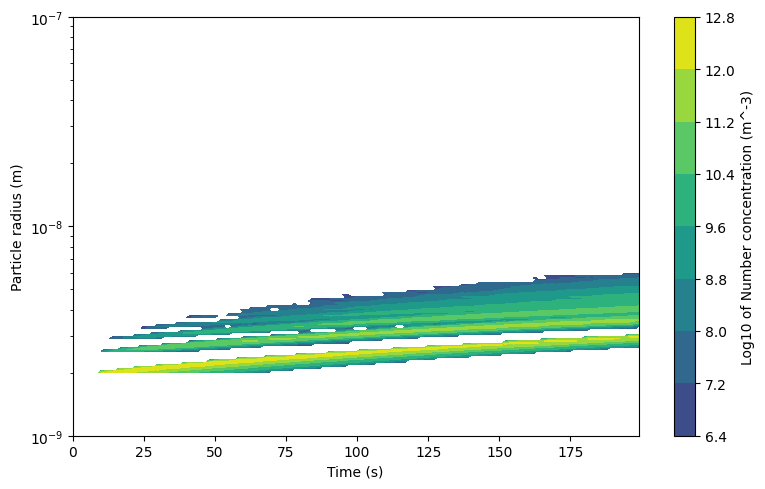

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Swap X and Y to reverse axes
X, Y = np.meshgrid(
    time, plot_edges[:-1]
)  # Now time is on the x-axis and edges on the y-axis

# Plot the contour with updated X and Y
log_of_number_distribution_binned = np.log10(
    number_distribution_binned,
    out=np.nan * np.ones_like(number_distribution_binned),
    where=number_distribution_binned > 0,
)
contour = ax.contourf(
    X,
    Y,
    log_of_number_distribution_binned.T,
    cmap="viridis",
    vmin=5,
)

# Add the color bar
cbar = fig.colorbar(contour)
cbar.set_label("Log10 of Number concentration (m^-3)")

ax.set_ylim(1e-9, 1e-7)  # Set limits for y-axis

# Set axis labels
ax.set_yscale("log")  # Log scale for particle radius on y-axis
ax.set_xlabel("Time (s)")
ax.set_ylabel("Particle radius (m)")
fig.tight_layout()
plt.show()

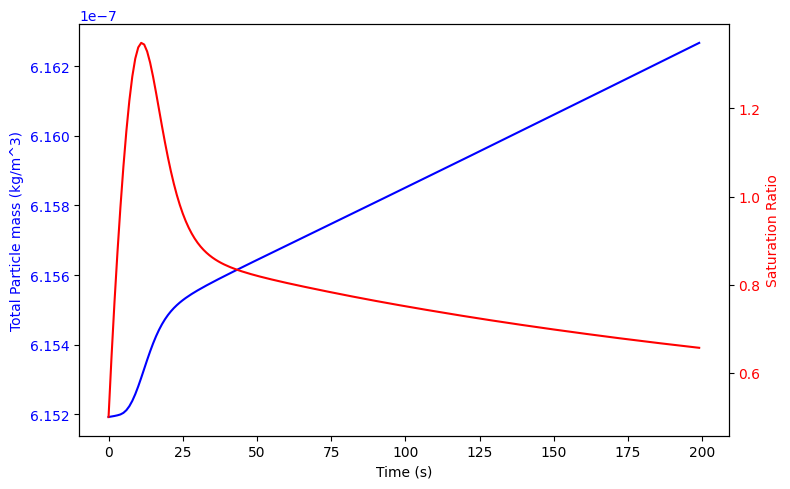

In [ ]:
# plot the total mass and water saturation on twin y-axis
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(time, total_mass_resolved, label="Total mass", color="blue")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Total Particle mass (kg/m^3)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(time, saturation_ratio_output, label="Satruation Ratio", color="red")
ax2.set_ylabel("Saturation Ratio", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

## Conclusion

In this guide, we demonstrated how to integrate custom nucleation processes into the aerosol simulation. This shows the flexibility of the aerosol model, allowing for the addition of new processes before they are fully integrated into the core framework.

*Note*: Custom nucleation, particularly at high rates, can significantly increase the number of particles simulated, potentially slowing down the computation. A rescaling mechanism to adjust the simulation volume and control the number of resolved particles is planned for future enhancements to address this issue.